In [1]:
import csv

# Read Nodes
nodes = {}
with open("final_cyclone_city_statues_with_coordinates.csv", 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        statue_id = row[0]
        lat = float(row[4])  # latitude
        lon = float(row[5])  # longitude
        nodes[statue_id] = (lat, lon)


In [2]:
import osmnx as ox

# Get the walking network around the nodes
locations = list(nodes.values())
center = (sum(lat for lat, lon in locations) / len(locations),
        sum(lon for lat, lon in locations) / len(locations))
# Set a reasonable buffer distance for the walking network
walking_graph = ox.graph_from_point(center, dist=10000, network_type='walk')

walking_graph



In [35]:
import time
import networkx as nx
from haversine import haversine

def add_nodes(graph, nodes):
    for node_id in nodes.keys():
        graph.add_node(node_id, lat=nodes[node_id][0], lon=nodes[node_id][1])
    return graph

def calculate_walking_distances(nodes, walking_graph):
    """
    Calculate walking distances between all pairs of nodes.

    Parameters:
        nodes: Dictionary of node IDs and their (lat, lon).
        walking_graph: The OSMnx graph for walking.

    Returns:
        A NetworkX weighted graph with walking distances.
    """
    print(f"Starting calculations for {len(nodes)} nodes...")
    total_pairs = len(nodes) * (len(nodes) - 1) // 2
    print(f"Total pairs to process: {total_pairs}")
    start_time = time.time()
    processed = 0
    G = nx.Graph()
    G = add_nodes(G, nodes)
    for node1 in G.nodes():
        node1_data = G.nodes[node1]
        print(node1_data)
        for node2 in G.nodes():
            if node2 != node1:
                node2_data = G.nodes[node2]
                processed += 1
                if processed % 10 == 0:  # Update every 10 pairs
                    elapsed = time.time() - start_time
                    rate = processed / elapsed if elapsed > 0 else 0
                    remaining_pairs = max(0, total_pairs - processed)//2
                    estimated_remaining_time = remaining_pairs / rate if rate > 0 else float('inf')
                    print(f"Processed {processed}/{total_pairs} pairs. "
                          f"Estimated time remaining: {max(0, estimated_remaining_time/60):.1f} minutes")

                # Find the nearest OSMnx nodes to our coordinates
                osm_node1 = ox.distance.nearest_nodes(walking_graph, node1_data["lon"], node1_data["lat"])
                osm_node2 = ox.distance.nearest_nodes(walking_graph, node2_data["lon"], node2_data["lat"])
                
                # Calculate the shortest walking distance between them
                try:
                    distance = nx.shortest_path_length(
                        walking_graph, source=osm_node1, target=osm_node2, weight='length'
                    )
                    # Convert distance from meters to miles
                    distance = distance * 0.000621371
                except nx.NetworkXNoPath:
                    distance = float('inf')  # No walking path found
                
                G.add_edge(node1, node2, weight=distance)
    
    total_time = time.time() - start_time
    print(f"\nCalculations complete! Total time: {total_time/60:.1f} minutes")
    return G

G = calculate_walking_distances(nodes, walking_graph)

Starting calculations for 27 nodes...
Total pairs to process: 351
{'lat': 42.0252596, 'lon': -93.6138957}
Processed 10/351 pairs. Estimated time remaining: 0.2 minutes
Processed 20/351 pairs. Estimated time remaining: 0.3 minutes
{'lat': 42.026112, 'lon': -93.614039}
Processed 30/351 pairs. Estimated time remaining: 0.2 minutes
Processed 40/351 pairs. Estimated time remaining: 0.2 minutes
Processed 50/351 pairs. Estimated time remaining: 0.2 minutes
{'lat': 42.026112, 'lon': -93.614037}
Processed 60/351 pairs. Estimated time remaining: 0.2 minutes
Processed 70/351 pairs. Estimated time remaining: 0.2 minutes
{'lat': 42.0263603, 'lon': -93.6179857}
Processed 80/351 pairs. Estimated time remaining: 0.2 minutes
Processed 90/351 pairs. Estimated time remaining: 0.2 minutes
Processed 100/351 pairs. Estimated time remaining: 0.2 minutes
{'lat': 42.02045595, 'lon': -93.6115800516611}
Processed 110/351 pairs. Estimated time remaining: 0.2 minutes
Processed 120/351 pairs. Estimated time remaini

In [32]:
import matplotlib.pyplot as plt
import contextily as ctx
from pyproj import Transformer
import math
import matplotlib.colors as mcolors

def draw_graph(nx_graph, path=None):
    transformer = Transformer.from_crs("epsg:4326", "epsg:3857", always_xy=True)
    pos = {}
    for n in nx_graph.nodes():
        lat, lon = nx_graph.nodes[n]['lat'], nx_graph.nodes[n]['lon']
        x, y = transformer.transform(lon, lat)
        pos[n] = (x, y)
    
    fig, axes = plt.subplots(1,1,dpi=70)
    
    # Draw all edges in gray first
    nx.draw_networkx_edges(nx_graph, pos, ax=axes, edge_color='gray', width=5)
    
    if path:
        # Create edge list from path
        path_edges = list(zip(path[:-1], path[1:]))
        # Draw path edges in red
        nx.draw_networkx_edges(nx_graph, pos, ax=axes, edgelist=path_edges, 
                             edge_color='red', width=2)
    
    # Draw nodes and labels
    nx.draw_networkx_nodes(nx_graph, pos, ax=axes, node_color='lightblue')
    nx.draw_networkx_labels(nx_graph, pos, ax=axes)
    
    ctx.add_basemap(axes, crs="EPSG:3857",
                   source=ctx.providers.OpenStreetMap.Mapnik,
                   zoom=14)
    plt.show()

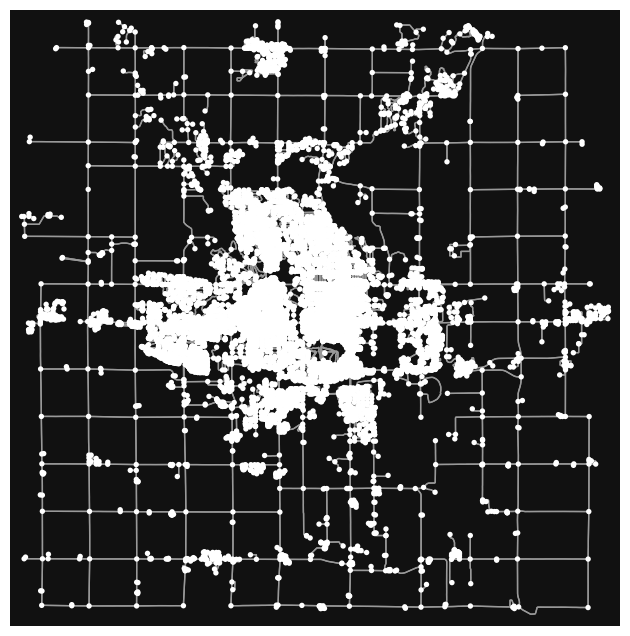

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [33]:
ox.plot_graph(walking_graph)

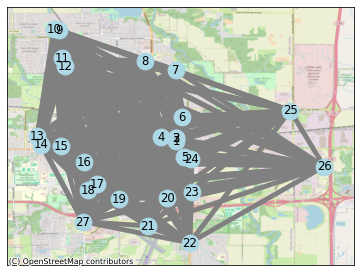

In [34]:
draw_graph(G)

In [51]:
def find_path_with_cost(graph, start, target_cost, tolerance=1):
    """
    Find a path in the graph whose total cost is approximately the target cost.

    Parameters:
        graph: NetworkX graph with edge weights.
        start: Starting node.
        target_cost: Desired total cost of the path.
        tolerance: Allowable deviation from the target cost.

    Returns:
        The path and its cost, or None if no such path exists.
    """
    def dfs(node, visited, current_cost, path):
        # Base case: Check if we're close enough to the target cost
        if abs(current_cost - target_cost) <= tolerance and len(path) == 27:
            return path, current_cost
        
        # Explore neighbors
        for neighbor in graph.neighbors(node):
            if neighbor not in visited:
                edge_cost = graph[node][neighbor]['weight']
                if current_cost + edge_cost <= target_cost + tolerance:  # Prune paths that exceed the cost
                    visited.add(neighbor)
                    result = dfs(neighbor, visited, current_cost + edge_cost, path + [neighbor])
                    if result:  # Found a valid path
                        return result
                    visited.remove(neighbor)  # Backtrack
        
        return None

    # Start DFS
    visited = set([start])
    return dfs(start, visited, 0, [start])
start_node = "13"
target_cost = 26.218
target_cost = 13.18
path, cost = find_path_with_cost(G, start_node, target_cost)
print(f"# of Nodes: {len(path)}")
if path:
    print(f"Path found: {path} with cost: {cost}")
else:
    print("No path found with the desired cost.")
draw_graph(G, path)

KeyboardInterrupt: 